**making emission csv**

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# List of file name prefixes
files = ["tp_m_", "tp_e_", "rm_m_", "rm_e_"]

# Correct directory where your XML files are stored
base_path = r"F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission"

# Loop through each file prefix
for f in files:
    tripinfo_file = os.path.join(base_path, f"{f}tripinfo.xml")
    
    # Check if file exists
    if not os.path.exists(tripinfo_file):
        print(f"❌ File not found: {tripinfo_file}")
        continue  # Skip this file if not found

    # Parse the XML
    tree = ET.parse(tripinfo_file)
    root = tree.getroot()
    
    trip_rows = []
    
    for trip in root.findall('tripinfo'):
        emissions = trip.find('emissions')
        row = {
            'vehicle_id': trip.attrib.get('id'),
            'depart': float(trip.attrib.get('depart', 0)),
            'arrival': float(trip.attrib.get('arrival', 0)),
            'duration': float(trip.attrib.get('duration', 0)),
            'routeLength': float(trip.attrib.get('routeLength', 0)),
            'waitingTime': float(trip.attrib.get('waitingTime', 0)),
            'timeLoss': float(trip.attrib.get('timeLoss', 0)),
            'vType': trip.attrib.get('vType'),
            'speedFactor': float(trip.attrib.get('speedFactor', 1)),
            # Emissions
            'CO_abs': float(emissions.attrib.get('CO_abs', 0)),
            'CO2_abs': float(emissions.attrib.get('CO2_abs', 0)),
            'HC_abs': float(emissions.attrib.get('HC_abs', 0)),
            'PMx_abs': float(emissions.attrib.get('PMx_abs', 0)),
            'NOx_abs': float(emissions.attrib.get('NOx_abs', 0)),
            'fuel_abs': float(emissions.attrib.get('fuel_abs', 0)),
            'electricity_abs': float(emissions.attrib.get('electricity_abs', 0)),
        }
        trip_rows.append(row)
    
    # Create DataFrame
    tripinfo_df = pd.DataFrame(trip_rows)
    
    # Encode vehicle type
    le = LabelEncoder()
    tripinfo_df['vType_encoded'] = le.fit_transform(tripinfo_df['vType'])
    
    # Save as CSV
    output_path = r"F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv"
    output_csv = os.path.join(output_path, f"{f}emission.csv")
    tripinfo_df.to_csv(output_csv, index=False)
    print(f"✅ {output_csv} saved")


✅ F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\tp_m_emission.csv saved
✅ F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\tp_e_emission.csv saved
✅ F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\rm_m_emission.csv saved
✅ F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\rm_e_emission.csv saved


**SHAP**

In [16]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\tp_m_emission.csv") #for mor tp_m and afternoon tp_e for diff shap

features = [
    "vType_encoded",
    "duration",
    "routeLength",
    "waitingTime",
    "timeLoss",
    "speedFactor",
    "depart",
    "arrival"
]
target = "CO2_abs"

X = df[features]
y = df[target]

y_log = np.log1p(y)  # log1p = log(1 + y), handles zeros safely

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Initialize model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

# Train model
rf_model.fit(X_train, y_train)

import shap
import matplotlib.pyplot as plt

# Create TreeExplainer specific for tree models like RandomForest
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [4]:
shap_values.shape

(726, 8)

**shap beeswarm**

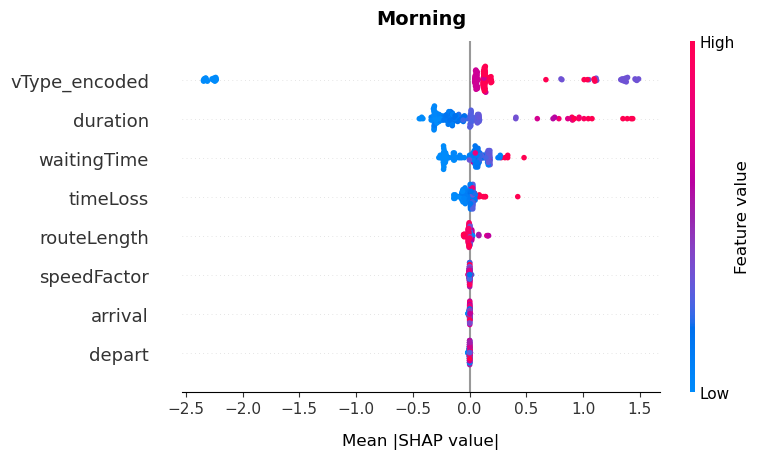

In [17]:
#plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Morning", fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Mean |SHAP value|", fontsize=12, labelpad=12)
plt.tight_layout()
plt.savefig("tp_morn_shap_beeswarm.pdf", dpi=1000, bbox_inches="tight")
plt.show()

**dependency plot**

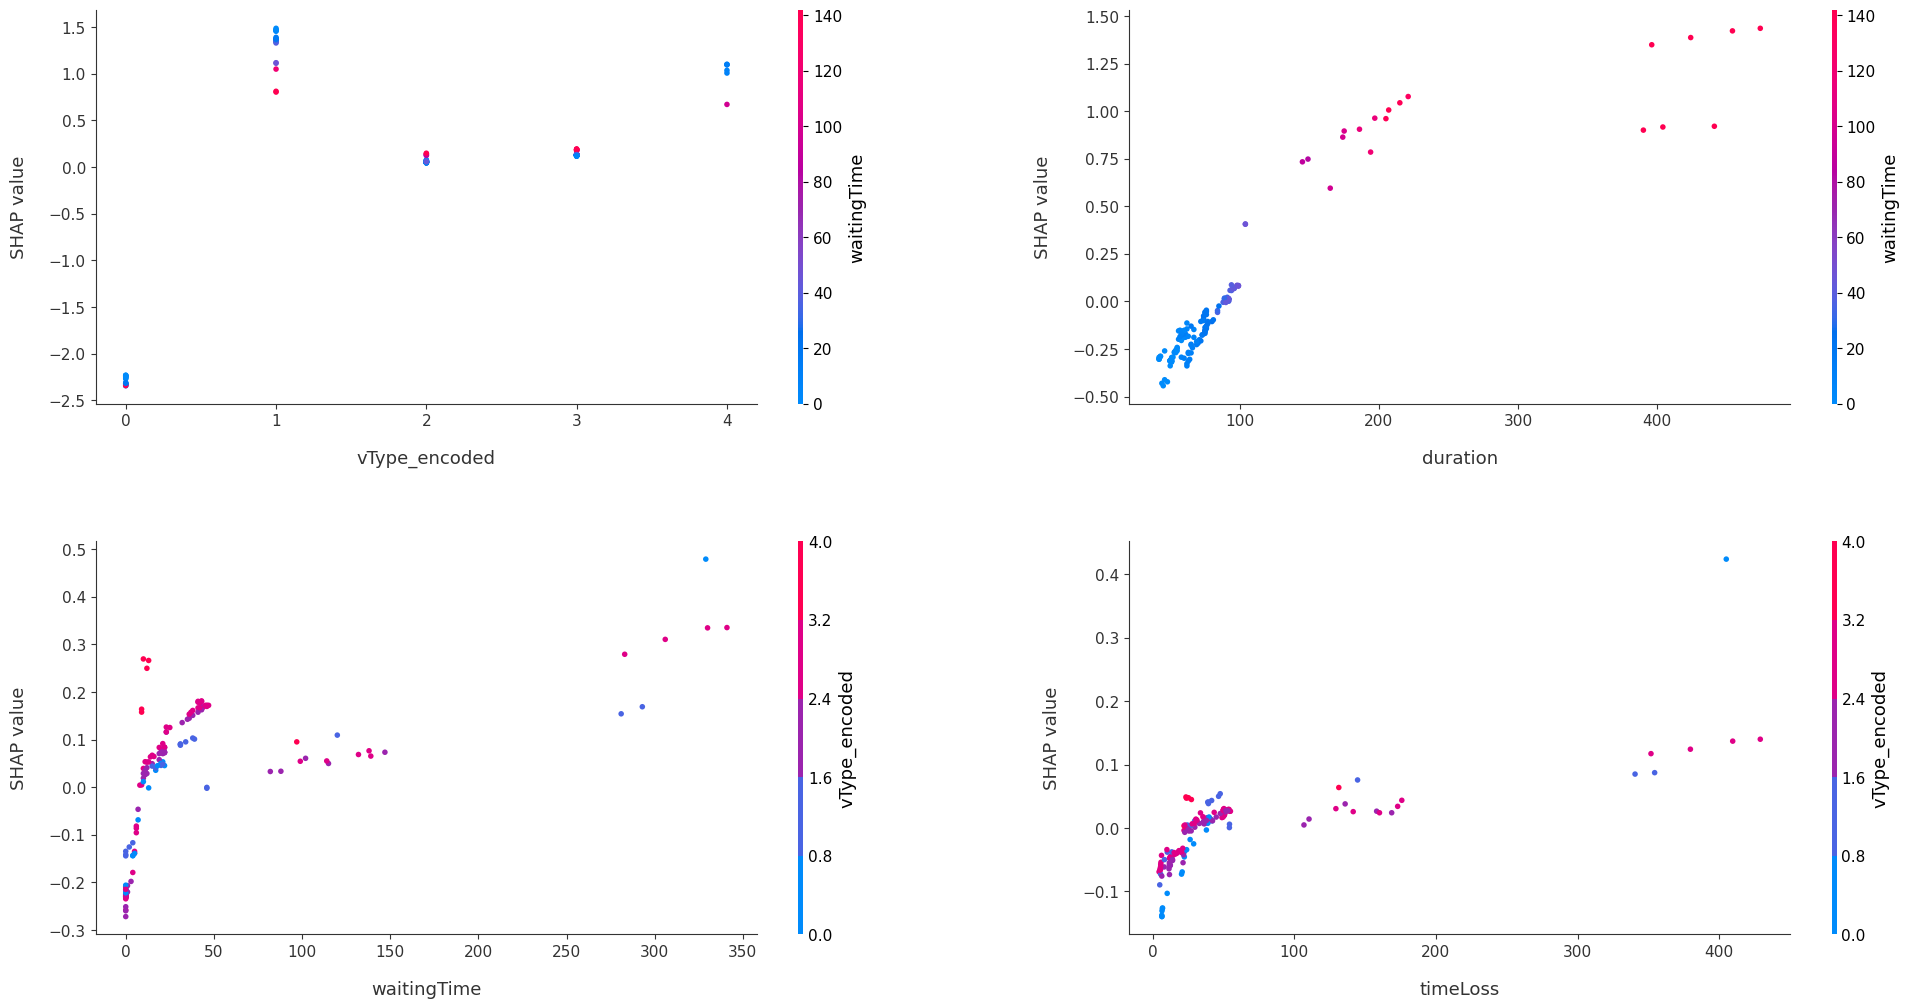

In [18]:
# Get mean absolute SHAP values to identify top features
mean_shap = np.abs(shap_values).mean(axis=0)

# Get indices of top 4 features
top_indices = np.argsort(mean_shap)[-4:][::-1]

# Get feature names
if hasattr(X_test, 'columns'):
    feature_names = X_test.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]

# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axes = axes.flatten()

# Plot dependency plots
for i, index in enumerate(top_indices):
    plt.sca(axes[i])  # Set current axis
    shap.dependence_plot(
        index, shap_values, X_test,
        ax=axes[i], show=False,
        feature_names=feature_names
    )

    # Set axis label padding
    axes[i].set_xlabel(feature_names[index], labelpad=15, fontsize=13)
    axes[i].set_ylabel("SHAP value", labelpad=15, fontsize=13)

    # Integer ticks for 'vType_encoded'
    if feature_names[index] == "vType_encoded":
        unique_vals = sorted(X_test["vType_encoded"].unique())
        axes[i].set_xticks(unique_vals)
        axes[i].set_xticklabels([str(int(val)) for val in unique_vals])

# Hide any unused subplots
for j in range(len(top_indices), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Save
plt.savefig("tp_morn_dep_plot.pdf", dpi=1000, bbox_inches="tight")
plt.show()

**combining all (RF+ SHAP PLOTS)**

**combined  shap BAR plot**


--- TP_M (Morning) ---
R² Score: 0.9893 | RMSE: 0.13 | MAE: 0.05

--- TP_E (Afternoon) ---
R² Score: 0.9994 | RMSE: 0.02 | MAE: 0.02


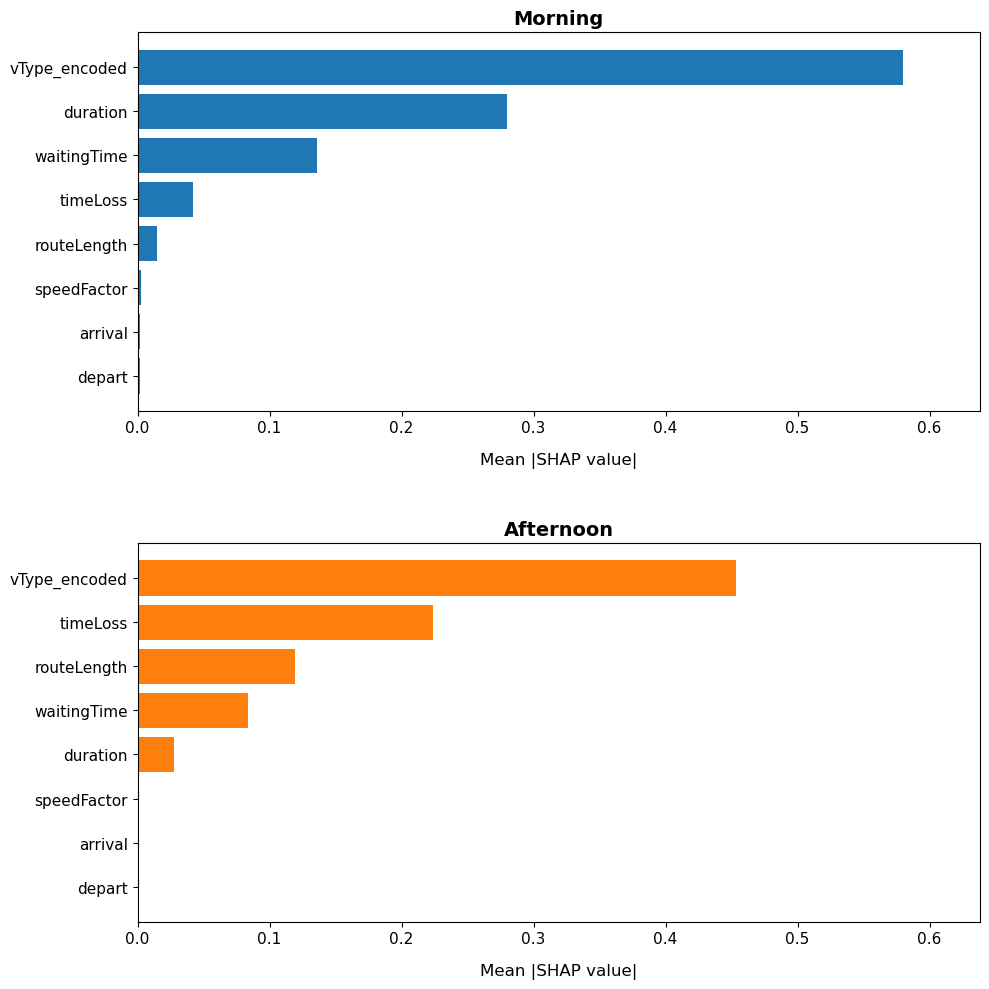

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

# ==========================
# Configurations
# ==========================
FEATURES = [
    "vType_encoded",
    "duration",
    "routeLength",
    "waitingTime",
    "timeLoss",
    "speedFactor",
    "depart",
    "arrival"
]
TARGET = "CO2_abs"
FILES = ['tp_m', 'tp_e']
TITLES = ['Morning', 'Afternoon']
COLORS = ['#1f77b4', '#ff7f0e']  # blue and orange

# ==========================
# Prepare Plot
# ==========================
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs = axs.flatten()

max_shap = 0  # for syncing x-axis later

for idx, file_key in enumerate(FILES):
    # ==========================
    # Load & Prepare Data
    # ==========================
    df = pd.read_csv(fr"F:\ALL Works\Emission Project\AAAA Main Job\DATA\emission csv\{file_key}_emission.csv")
    X = df[FEATURES]
    y = np.log1p(df[TARGET])  # log-transform for stability

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ==========================
    # Train Model
    # ==========================
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ==========================
    # Evaluate Model
    # ==========================
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- {file_key.upper()} ({TITLES[idx]}) ---")
    print(f"R² Score: {r2:.4f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

    # ==========================
    # SHAP Analysis
    # ==========================
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Mean absolute SHAP values
    mean_shap = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(mean_shap)
    sorted_features = np.array(FEATURES)[sorted_idx]
    sorted_shap = mean_shap[sorted_idx]

    max_shap = max(max_shap, np.max(sorted_shap))  # track for axis sync

    # ==========================
    # Plotting
    # ==========================
    ax = axs[idx]
    ax.barh(sorted_features, sorted_shap, color=COLORS[idx])
    ax.set_title(f"{TITLES[idx]}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Mean |SHAP value|", fontsize=12, labelpad=12)
    ax.tick_params(axis='both', labelsize=11)
    #ax.grid(True, linestyle='--', alpha=0.4)

# ==========================
# Final Layout Adjustments
# ==========================
for ax in axs:
    ax.set_xlim(0, max_shap * 1.1)  # sync x-axis

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)

# ==========================
# Save Figure
# ==========================
plt.savefig("shap_bar_plot_tigerpass_both.pdf", dpi=1000, bbox_inches="tight")
plt.show()